# TP2

Este cuaderno implementa:
- **ISM** (Image Sharpness Measure en dominio frecuencia).
- Experimentos: **todo el frame**, **ROI central 10% y 5%**, y **matrices NxM** (≥3 configuraciones).
- **Curvas** de la métrica vs frame con **detección de máximo**.
- **Métrica alternativa** (Laplacian variance).
- **Unsharp masking** y recálculo de la métrica (extra).


In [25]:
# Utilidades generales
import numpy as np, cv2, matplotlib.pyplot as plt

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img

def crop_center_roi(img, frac=0.1):
    h, w = img.shape[:2]
    dh, dw = int(h*frac), int(w*frac)
    y0 = (h-dh)//2; x0 = (w-dw)//2
    return img[y0:y0+dh, x0:x0+dw]


In [26]:
# --- ISM (Image Sharpness Measure en frecuencia) ---
def ism_metric(gray, hp_ratio=0.2):
    gray = to_gray(gray).astype(np.float32)
    h, w = gray.shape
    # ventana para minimizar leakage
    win = np.outer(np.hanning(h), np.hanning(w)).astype(np.float32)
    g = gray * win
    # FFT
    F = np.fft.fftshift(np.fft.fft2(g))
    mag = np.abs(F)
    # máscara de altas frecuencias
    cy, cx = h//2, w//2
    Y, X = np.ogrid[:h, :w]
    r = np.sqrt((Y-cy)**2 + (X-cx)**2)
    r_max = np.sqrt(cy**2 + cx**2)
    mask = (r > (hp_ratio*r_max)).astype(np.float32)
    num = (mag * mask).sum()
    den = mag.sum() + 1e-12
    return float(num/den)


In [27]:
# --- Métricas alternativas ---
def lap4_metric(gray, ksize=3):
    g = to_gray(gray).astype(np.float32)
    lap = cv2.Laplacian(g, cv2.CV_32F, ksize=ksize)
    return float(np.var(lap))

def tenengrad_metric(gray):
    g = to_gray(gray).astype(np.float32)
    gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3)
    return float(np.mean(gx*gx + gy*gy))


In [28]:
# --- Unsharp masking (extra) ---
def unsharp(img_bgr, size=(7,7), sigma=1.0, k=1.0):
    blur = cv2.GaussianBlur(img_bgr, size, sigma)
    return cv2.addWeighted(img_bgr, 1.0 + k, blur, -k, 0)


In [29]:
# --- Focus measure por frame + ROI / grilla ---
def focus_measure(frames, mode='full', metric='ISM', roi_frac=0.1, grid=(3,3)):
    """Calcula la métrica por frame.
    mode: 'full' | 'roi' | 'grid'
    metric: 'ISM' | 'LAP4' | 'TENG'
    roi_frac: fracción de lado para ROI central (0.05 ó 0.10 típicamente)
    grid: (N, M) para matriz de enfoque
    Devuelve: metrics(list[float]), pts(list[lista de puntos] o None)
    """
    def mfun(img):
        if metric.upper()=='ISM':   return ism_metric(img)
        if metric.upper()=='LAP4':  return lap4_metric(img)
        if metric.upper()=='TENG':  return tenengrad_metric(img)
        return ism_metric(img)

    metrics=[]; pts=[]
    for f in frames:
        if mode=='full':
            metrics.append(mfun(f))
            pts.append(None)
        elif mode=='roi':
            roi = crop_center_roi(f, roi_frac)
            metrics.append(mfun(roi))
            # guardo corners de diagnóstico en coords globales
            g = to_gray(roi)
            cs = cv2.goodFeaturesToTrack(g, 60, 0.01, 7)
            if cs is not None:
                y0 = (f.shape[0]-roi.shape[0])//2; x0 = (f.shape[1]-roi.shape[1])//2
                pts.append([(int(c[0][0]+x0), int(c[0][1]+y0)) for c in cs])
            else:
                pts.append([])
        elif mode=='grid':
            N, M = grid
            H, W = f.shape[:2]
            sh, sw = H//N, W//M
            val = 0.0
            plist=[]
            for i in range(N):
                for j in range(M):
                    patch = f[i*sh:(i+1)*sh, j*sw:(j+1)*sw]
                    val += mfun(patch)
                    # punto central del patch para visualizar
                    cx = j*sw + sw//2; cy = i*sh + sh//2
                    plist.append((cx, cy))
            val /= (N*M)
            metrics.append(val)
            pts.append(plist)
        else:
            metrics.append(mfun(f))
            pts.append(None)
    return metrics, pts


In [30]:
# --- Visualización de curvas y detección de máximo ---
def showMetric(metrics, percentile, title, label='metric'):
    import numpy as np, matplotlib.pyplot as plt
    metrics = np.asarray(metrics, dtype=float)
    thr = np.percentile(metrics, percentile)
    i_max = int(np.argmax(metrics))
    plt.figure(figsize=(7,3))
    plt.plot(metrics, 'o-', markersize=3)
    plt.axhline(thr, ls='--', lw=1, label=f'P{percentile}')
    plt.axvline(i_max, ls=':', lw=1, color='r', label=f'máx: {i_max}')
    plt.title(title)
    plt.xlabel('Frame #'); plt.ylabel(label); plt.legend(); plt.grid(True)
    plt.show()
    print(f"Frame de máximo enfoque: {i_max} (valor={metrics[i_max]:.4f})")


In [31]:
# --- Muestra de video compatible con Colab/Jupyter ---
import time, cv2
from IPython.display import clear_output
def showVideo(frames, delay_ms=30, title="", pts=None, enfoco=None, bgr=True):
    try:
        from google.colab.patches import cv2_imshow
        use_colab = True
    except Exception:
        use_colab = False
        import matplotlib.pyplot as plt
    for i, f in enumerate(frames):
        vis = f.copy()
        if pts is not None and i < len(pts) and pts[i] is not None:
            for p in pts[i]:
                x, y = int(p[0]), int(p[1])
                cv2.circle(vis, (x, y), 3, (0,255,0), -1, cv2.LINE_AA)
        if enfoco is not None and i < len(enfoco):
            ok = bool(enfoco[i]); txt='IN FOCUS' if ok else 'OUT OF FOCUS'
            col=(0,255,0) if ok else (0,0,255)
            cv2.putText(vis, txt, (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, col, 2, cv2.LINE_AA)
        clear_output(wait=True)
        if use_colab:
            if not bgr: vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
            cv2_imshow(vis)
        else:
            plt.figure(figsize=(6,4))
            img = vis if not bgr else cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
            plt.imshow(img); plt.title(title); plt.axis('off'); plt.show()
        time.sleep(max(1, int(delay_ms))/1000.0)
    clear_output(wait=False)


In [32]:
# === Carga del video focus_video.mov desde GitHub ===
import cv2
import numpy as np
import urllib.request
import tempfile

video_url = "https://raw.githubusercontent.com/MartinAndu/Vision_Computadora_1_CEIA/main/TP2/focus_video.mov"

# Descargar temporalmente el video a un archivo local
tmp_video = tempfile.NamedTemporaryFile(delete=False, suffix=".mov")
urllib.request.urlretrieve(video_url, tmp_video.name)

# Cargar con OpenCV
cap = cv2.VideoCapture(tmp_video.name)
video_frames = []

if not cap.isOpened():
    print("⚠️ No se pudo abrir el video desde GitHub.")
else:
    print("Cargando frames del video desde GitHub...")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames.append(frame)
    cap.release()
    print(f"✅ Se cargaron {len(video_frames)} frames correctamente.")


Cargando frames del video desde GitHub...
✅ Se cargaron 171 frames correctamente.


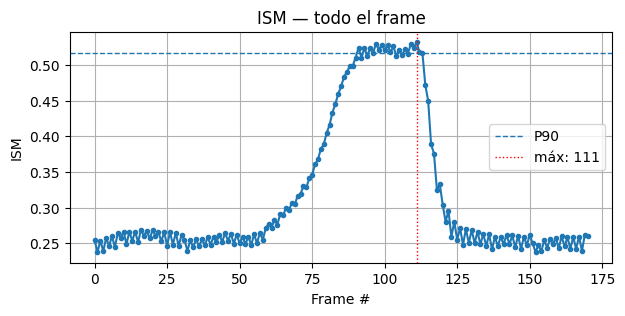

Frame de máximo enfoque: 111 (valor=0.5319)


In [33]:
# === Experimento 1: TODO EL FRAME (ISM) ===
percentile = 90
metrics, pts = focus_measure(video_frames, mode='full', metric='ISM')
showMetric(metrics, percentile, 'ISM — todo el frame', 'ISM')
enfoco = [m >= np.percentile(metrics, percentile) for m in metrics]
# showVideo(video_frames, 20, 'ISM full', pts, enfoco)  # opcional


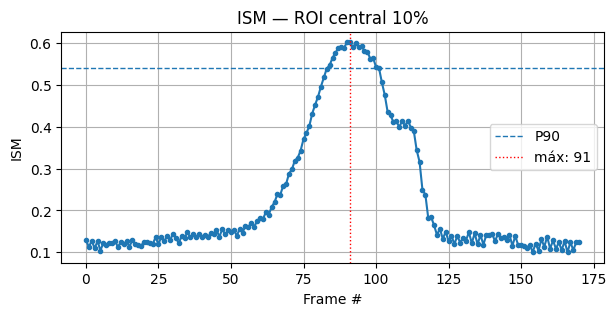

Frame de máximo enfoque: 91 (valor=0.6025)


In [34]:
# === Experimento 2: ROI CENTRAL 10% (ISM) ===
percentile = 90
metrics_roi10, pts_roi10 = focus_measure(video_frames, mode='roi', metric='ISM', roi_frac=0.10)
showMetric(metrics_roi10, percentile, 'ISM — ROI central 10%', 'ISM')


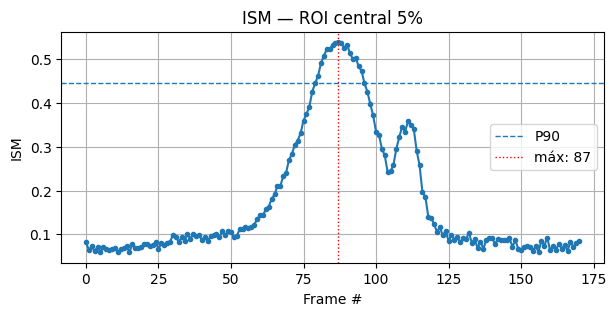

Frame de máximo enfoque: 87 (valor=0.5386)


In [35]:
# === Experimento 2b: ROI CENTRAL 5% (ISM) ===
percentile = 90
metrics_roi5, pts_roi5 = focus_measure(video_frames, mode='roi', metric='ISM', roi_frac=0.05)
showMetric(metrics_roi5, percentile, 'ISM — ROI central 5%', 'ISM')


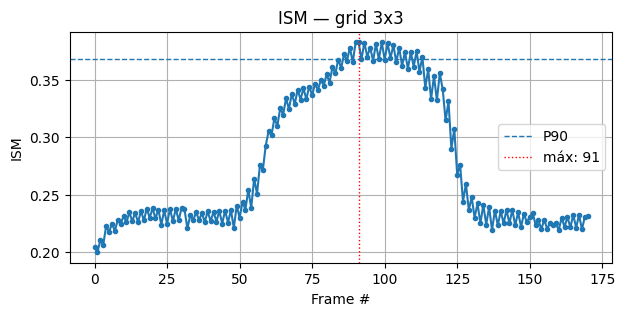

Frame de máximo enfoque: 91 (valor=0.3826)


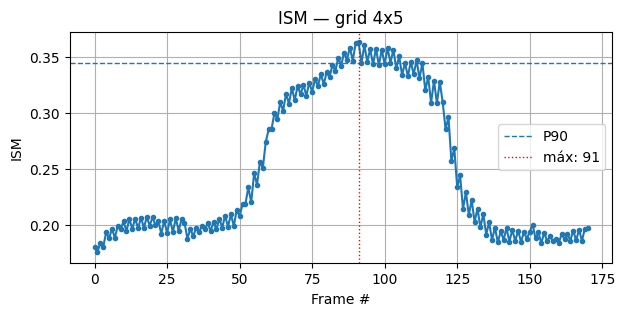

Frame de máximo enfoque: 91 (valor=0.3630)


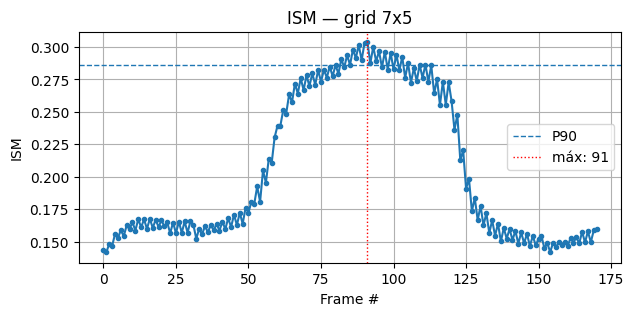

Frame de máximo enfoque: 91 (valor=0.3037)


In [36]:
# === Experimento 3 (opcional): MATRIZ NxM de enfoque (≥3 configuraciones) ===
percentile = 90
for grid in [(3,3),(4,5),(7,5)]:
    metrics_g, pts_g = focus_measure(video_frames, mode='grid', metric='ISM', grid=grid)
    showMetric(metrics_g, percentile, f'ISM — grid {grid[0]}x{grid[1]}', 'ISM')


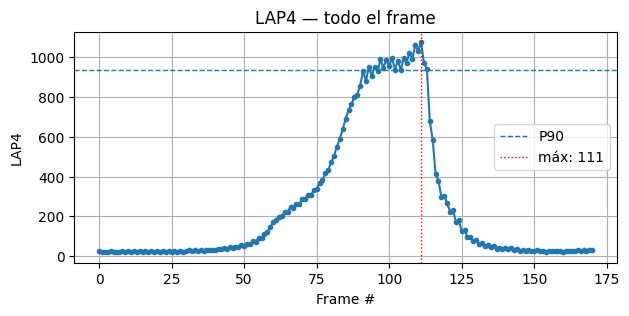

Frame de máximo enfoque: 111 (valor=1074.9932)


In [37]:
# === Punto 2: Métrica alternativa (Laplacian variance) ===
percentile = 90
metrics_lap, _ = focus_measure(video_frames, mode='full', metric='LAP4')
showMetric(metrics_lap, percentile, 'LAP4 — todo el frame', 'LAP4')


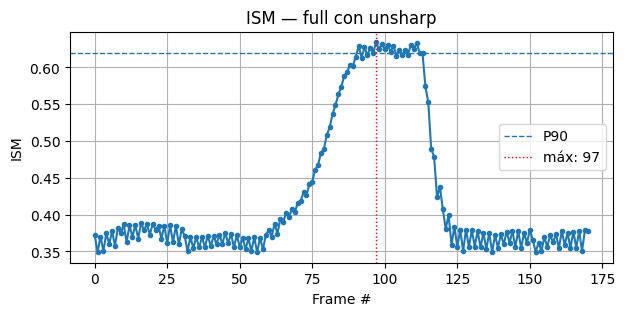

Frame de máximo enfoque: 97 (valor=0.6343)


In [38]:
# === Extra: Unsharp masking + ISM ===
# Aplico unsharp frame a frame y recalculo ISM (full frame)
sharpened = [unsharp(f, (7,7), 1.0, 1.0) for f in video_frames]
percentile = 90
metrics_sharp, _ = focus_measure(sharpened, mode='full', metric='ISM')
showMetric(metrics_sharp, percentile, 'ISM — full con unsharp', 'ISM')


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

DETECTOR DE MÁXIMO ENFOQUE - ANÁLISIS ESPECTRAL
Video: focus_video.mov
Frames: 171
Resolución: 640x360
FPS: 29.97002997002997

Experimento 1: Frame completo
Procesando frames completos...
  Frame 10/171
  Frame 20/171
  Frame 30/171
  Frame 40/171
  Frame 50/171
  Frame 60/171
  Frame 70/171
  Frame 80/171
  Frame 90/171
  Frame 100/171
  Frame 110/171
  Frame 120/171
  Frame 130/171
  Frame 140/171
  Frame 150/171
  Frame 160/171
  Frame 170/171
  Mejor enfoque en frame: 111

Experimento 2: ROI Central
Procesando ROI central (5.0% del área)...
  Frame 10/171
  Frame 20/171
  Frame 30/171
  Frame 40/171
  Frame 50/171
  Frame 60/171
  Frame 70/171
  Frame 80/171
  Frame 90/171
  Frame 100/171
  Frame 110/171
  Frame 120/171
  Frame 130/171
  Frame 140/171
  Frame 150/171
  Frame 160/171
  Frame 170/171
  ROI 5% - Mejor enfoque en frame: 97
Procesando ROI central (10.0% del área)...
  Frame 10/171
  Frame 20/171
  Frame 30/171
  Frame 40/171
  Frame 50/171
  Frame 60/171
  Frame 70/171


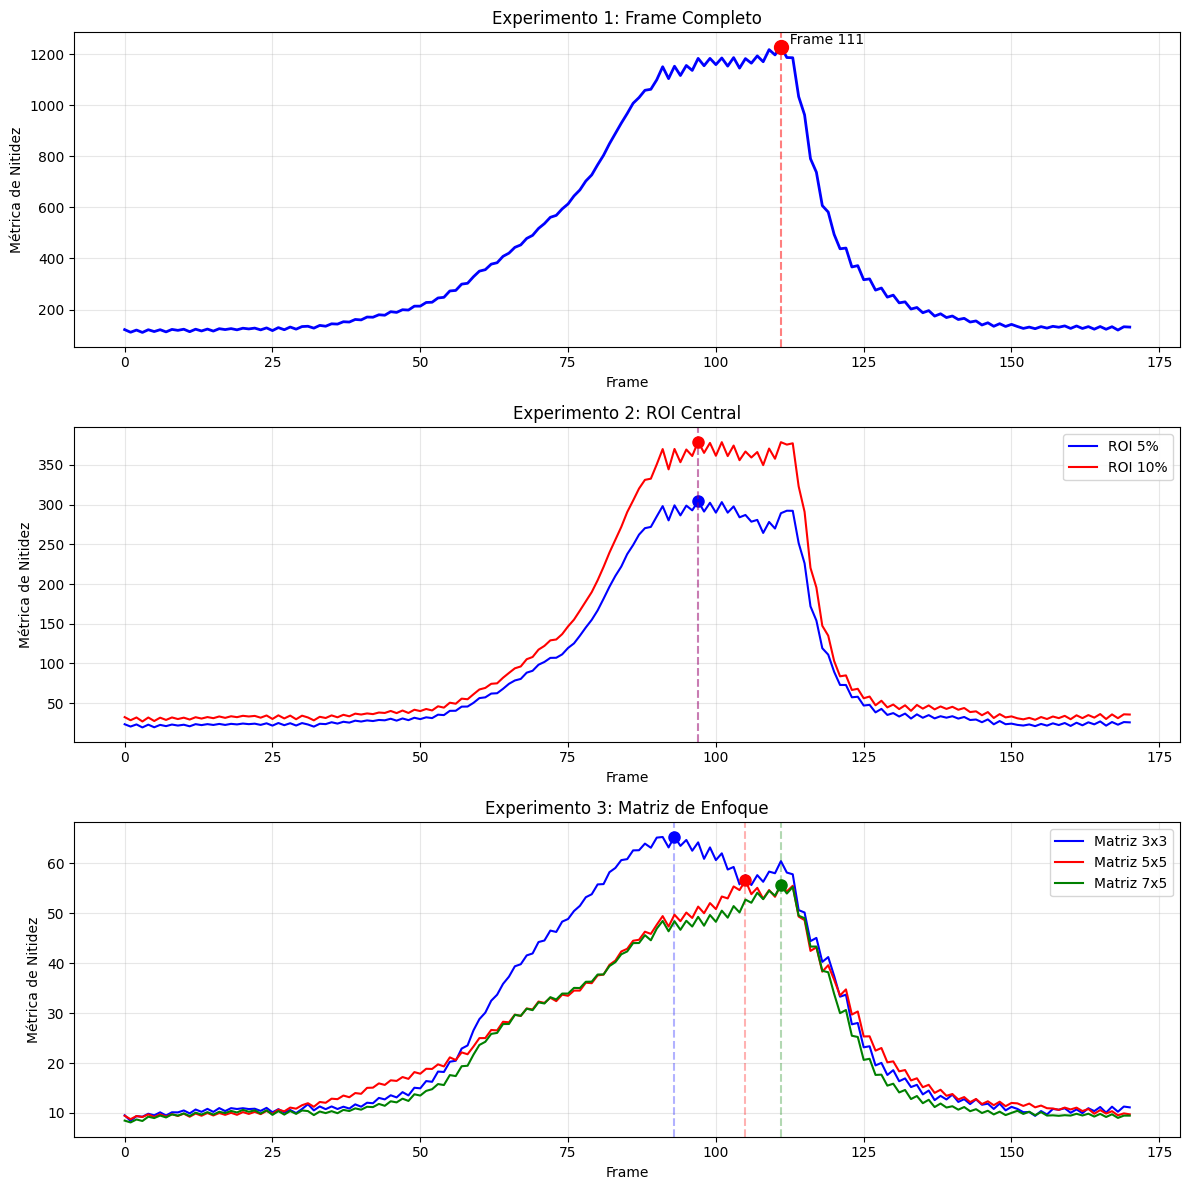


Análisis completado

Guardando resultados numéricos...
Resultados guardados en 'focus_metrics.txt'
Gráficas guardadas en 'focus_analysis.png'


In [40]:
class FocusDetector:
    """
    Detector de máximo enfoque basado en análisis espectral.
    Implementa la métrica del paper "Image Sharpness Measure for Blurred Images in Frequency Domain"
    """

    def __init__(self, video_path):
        """
        Inicializa el detector con el video a procesar.

        Args:
            video_path: Ruta al archivo de video
        """
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    def calculate_sharpness_metric(self, image):
        """
        Calcula la métrica de nitidez basada en el dominio de frecuencias.

        La métrica se basa en la suma de las magnitudes de las altas frecuencias
        en el espectro de Fourier, normalizada por el tamaño de la imagen.

        Args:
            image: Imagen en escala de grises

        Returns:
            float: Valor de la métrica de nitidez
        """
        # Aplicar ventana de Hanning para reducir artefactos de borde
        rows, cols = image.shape
        window_row = np.hanning(rows)
        window_col = np.hanning(cols)
        window = np.outer(window_row, window_col)
        windowed_image = image * window

        # Calcular FFT 2D
        f_transform = np.fft.fft2(windowed_image)
        f_shift = np.fft.fftshift(f_transform)

        # Calcular magnitud del espectro
        magnitude = np.abs(f_shift)

        # Crear máscara para altas frecuencias
        center_x, center_y = rows // 2, cols // 2

        # Radio para definir la región de altas frecuencias (>20% del radio máximo)
        max_radius = min(center_x, center_y)
        min_radius = int(max_radius * 0.2)

        # Crear meshgrid para calcular distancias
        y, x = np.ogrid[:rows, :cols]
        distance = np.sqrt((x - center_y)**2 + (y - center_x)**2)

        # Máscara para altas frecuencias
        high_freq_mask = distance > min_radius

        # Calcular métrica: suma de magnitudes en altas frecuencias
        high_freq_sum = np.sum(magnitude * high_freq_mask)

        # Normalizar por el área de la imagen
        metric = high_freq_sum / (rows * cols)

        return metric

    def process_full_frame(self):
        """
        Procesa el video completo calculando la métrica sobre cada frame completo.

        Returns:
            list: Valores de la métrica para cada frame
        """
        print("Procesando frames completos...")
        metrics = []
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

        for i in range(self.frame_count):
            ret, frame = self.cap.read()
            if not ret:
                break

            # Convertir a escala de grises
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Calcular métrica
            metric = self.calculate_sharpness_metric(gray)
            metrics.append(metric)

            if (i + 1) % 10 == 0:
                print(f"  Frame {i+1}/{self.frame_count}")

        return metrics

    def process_center_roi(self, roi_percentage=0.05):
        """
        Procesa el video calculando la métrica sobre una ROI central.

        Args:
            roi_percentage: Porcentaje del área total para la ROI (0.05 o 0.1)

        Returns:
            list: Valores de la métrica para cada frame
        """
        print(f"Procesando ROI central ({roi_percentage*100}% del área)...")
        metrics = []
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

        # Calcular dimensiones de la ROI
        roi_area = self.width * self.height * roi_percentage
        roi_side = int(np.sqrt(roi_area))

        # Coordenadas de la ROI central
        x_center = self.width // 2
        y_center = self.height // 2
        x1 = x_center - roi_side // 2
        x2 = x_center + roi_side // 2
        y1 = y_center - roi_side // 2
        y2 = y_center + roi_side // 2

        for i in range(self.frame_count):
            ret, frame = self.cap.read()
            if not ret:
                break

            # Convertir a escala de grises y extraer ROI
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            roi = gray[y1:y2, x1:x2]

            # Calcular métrica
            metric = self.calculate_sharpness_metric(roi)
            metrics.append(metric)

            if (i + 1) % 10 == 0:
                print(f"  Frame {i+1}/{self.frame_count}")

        return metrics

    def process_focus_matrix(self, n_rows=3, n_cols=3):
        """
        Procesa el video con una matriz de enfoque NxM.

        Args:
            n_rows: Número de filas en la matriz
            n_cols: Número de columnas en la matriz

        Returns:
            list: Valores de la métrica promedio para cada frame
        """
        print(f"Procesando matriz de enfoque {n_rows}x{n_cols}...")
        metrics = []
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

        # Calcular tamaño y espaciado de las celdas
        cell_width = self.width // (n_cols + 1)
        cell_height = self.height // (n_rows + 1)

        # Posiciones de las celdas
        x_positions = np.linspace(cell_width, self.width - cell_width, n_cols, dtype=int)
        y_positions = np.linspace(cell_height, self.height - cell_height, n_rows, dtype=int)

        # Tamaño de cada celda (10% del frame)
        cell_size_w = self.width // 10
        cell_size_h = self.height // 10

        for i in range(self.frame_count):
            ret, frame = self.cap.read()
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_metrics = []

            # Calcular métrica para cada celda de la matriz
            for y in y_positions:
                for x in x_positions:
                    x1 = max(0, x - cell_size_w // 2)
                    x2 = min(self.width, x + cell_size_w // 2)
                    y1 = max(0, y - cell_size_h // 2)
                    y2 = min(self.height, y + cell_size_h // 2)

                    roi = gray[y1:y2, x1:x2]
                    metric = self.calculate_sharpness_metric(roi)
                    frame_metrics.append(metric)

            # Promedio de todas las celdas
            metrics.append(np.mean(frame_metrics))

            if (i + 1) % 10 == 0:
                print(f"  Frame {i+1}/{self.frame_count}")

        return metrics

    def find_best_focus(self, metrics):
        """
        Encuentra el frame con mejor enfoque.

        Args:
            metrics: Lista de métricas

        Returns:
            int: Índice del frame con mejor enfoque
        """
        return np.argmax(metrics)

    def plot_results(self, experiments_data, save_path="focus_analysis.png"):
        """
        Grafica los resultados de todos los experimentos.

        Args:
            experiments_data: Diccionario con los datos de cada experimento
            save_path: Ruta para guardar la figura
        """
        n_experiments = len(experiments_data)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(12, 4*n_experiments))

        if n_experiments == 1:
            axes = [axes]

        colors = ['blue', 'red', 'green', 'orange', 'purple']

        for idx, (exp_name, exp_data) in enumerate(experiments_data.items()):
            ax = axes[idx]

            if isinstance(exp_data, dict):
                # Múltiples curvas en un experimento
                for i, (config_name, metrics) in enumerate(exp_data.items()):
                    frames = np.arange(len(metrics))
                    ax.plot(frames, metrics, label=config_name,
                           color=colors[i % len(colors)], linewidth=1.5)

                    # Marcar punto de máximo enfoque
                    best_idx = self.find_best_focus(metrics)
                    ax.plot(best_idx, metrics[best_idx], 'o',
                           color=colors[i % len(colors)], markersize=8)
                    ax.axvline(x=best_idx, color=colors[i % len(colors)],
                              linestyle='--', alpha=0.3)

                ax.legend(loc='upper right')
            else:
                # Una sola curva
                frames = np.arange(len(exp_data))
                ax.plot(frames, exp_data, 'b-', linewidth=2)

                # Marcar punto de máximo enfoque
                best_idx = self.find_best_focus(exp_data)
                ax.plot(best_idx, exp_data[best_idx], 'ro', markersize=10)
                ax.axvline(x=best_idx, color='red', linestyle='--', alpha=0.5)
                ax.text(best_idx, exp_data[best_idx], f'  Frame {best_idx}',
                       fontsize=10, va='bottom')

            ax.set_xlabel('Frame')
            ax.set_ylabel('Métrica de Nitidez')
            ax.set_title(exp_name)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

    def run_all_experiments(self):
        """
        Ejecuta todos los experimentos requeridos.
        """
        print("="*60)
        print("DETECTOR DE MÁXIMO ENFOQUE - ANÁLISIS ESPECTRAL")
        print("="*60)
        print(f"Video: {self.video_path}")
        print(f"Frames: {self.frame_count}")
        print(f"Resolución: {self.width}x{self.height}")
        print(f"FPS: {self.fps}")
        print("="*60)

        results = {}

        # Experimento 1: Frame completo
        print("\nExperimento 1: Frame completo")
        metrics_full = self.process_full_frame()
        results["Experimento 1: Frame Completo"] = metrics_full
        best_frame = self.find_best_focus(metrics_full)
        print(f"  Mejor enfoque en frame: {best_frame}")

        # Experimento 2: ROI central (5% y 10%)
        print("\nExperimento 2: ROI Central")
        roi_results = {}

        metrics_roi_5 = self.process_center_roi(0.05)
        roi_results["ROI 5%"] = metrics_roi_5
        best_frame_5 = self.find_best_focus(metrics_roi_5)
        print(f"  ROI 5% - Mejor enfoque en frame: {best_frame_5}")

        metrics_roi_10 = self.process_center_roi(0.10)
        roi_results["ROI 10%"] = metrics_roi_10
        best_frame_10 = self.find_best_focus(metrics_roi_10)
        print(f"  ROI 10% - Mejor enfoque en frame: {best_frame_10}")

        results["Experimento 2: ROI Central"] = roi_results

        # Experimento 3 (Opcional): Matriz de enfoque
        print("\nExperimento 3: Matriz de Enfoque")
        matrix_results = {}

        configurations = [(3, 3), (5, 5), (7, 5)]
        for n_rows, n_cols in configurations:
            metrics_matrix = self.process_focus_matrix(n_rows, n_cols)
            matrix_results[f"Matriz {n_rows}x{n_cols}"] = metrics_matrix
            best_frame_matrix = self.find_best_focus(metrics_matrix)
            print(f"  Matriz {n_rows}x{n_cols} - Mejor enfoque en frame: {best_frame_matrix}")

        results["Experimento 3: Matriz de Enfoque"] = matrix_results

        # Graficar resultados
        print("\nGenerando gráficas...")
        self.plot_results(results)

        print("\n" + "="*60)
        print("Análisis completado")
        print("="*60)

        return results

# Función principal para ejecutar el detector
def main():
    """
    Función principal para ejecutar el detector de enfoque.
    """
    # Ruta al video
    video_path = "focus_video.mov"

    # Verificar que el archivo existe
    if not Path(video_path).exists():
        print(f"Error: No se encuentra el archivo {video_path}")
        print("Por favor, asegúrese de que el video esté en el directorio actual.")
        return

    # Crear y ejecutar el detector
    detector = FocusDetector(video_path)
    results = detector.run_all_experiments()

    # Guardar resultados numéricos
    print("\nGuardando resultados numéricos...")
    with open("focus_metrics.txt", "w") as f:
        for exp_name, exp_data in results.items():
            f.write(f"\n{exp_name}\n")
            f.write("="*50 + "\n")

            if isinstance(exp_data, dict):
                for config_name, metrics in exp_data.items():
                    best_idx = np.argmax(metrics)
                    f.write(f"\n{config_name}:\n")
                    f.write(f"  Mejor enfoque: Frame {best_idx}\n")
                    f.write(f"  Valor máximo: {metrics[best_idx]:.6f}\n")
                    f.write(f"  Valor mínimo: {min(metrics):.6f}\n")
                    f.write(f"  Rango dinámico: {max(metrics)/min(metrics):.2f}x\n")
            else:
                best_idx = np.argmax(exp_data)
                f.write(f"  Mejor enfoque: Frame {best_idx}\n")
                f.write(f"  Valor máximo: {exp_data[best_idx]:.6f}\n")
                f.write(f"  Valor mínimo: {min(exp_data):.6f}\n")
                f.write(f"  Rango dinámico: {max(exp_data)/min(exp_data):.2f}x\n")

    print("Resultados guardados en 'focus_metrics.txt'")
    print("Gráficas guardadas en 'focus_analysis.png'")

if __name__ == "__main__":
    main()